<div class="alert alert-block alert-info">

<b>Thank you for contributing to TeachOpenCADD!</b>

</div>

<div class="alert alert-block alert-info">

<b>Set up your PR</b>: Please check out our <a href="https://github.com/volkamerlab/teachopencadd/issues/41">issue</a> on how to set up a PR for new talktorials, including standard checks and TODOs.

</div>

# T037 · An introduction to $\text{E}(3)$-equivariant graph neural networks

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Joschka Groß, 2022, Chair for Modelling and Simulation, Saarland University,

## Aim of this talktorial

This talktorial is supposed to serve as an introduction to molecular machine learning on point clouds, i.e., molecular graphs that are embedded into euclidean space (see **Talktorial 033**). You will learn why euclidean equivariance and invariance are important properties of neural networks (NNs) that take point clouds as input and learn how to implement and train such NNs. In addition to discussing them in theory, this notebook also aims to demonstrate the shortcomings of plain graph neural networks (GNNs) when working with point clouds practically.

### Contents in *Theory*

* Why 3D coordinates?
* Representing molecules as point clouds, mathematically
* Equivariance and invariance in euclidean space and why we care
* How to construct $\text{E}(n)$-invariant and equivariant models
* The QM9 dataset

### Contents in *Practical*

* Visualization of point clouds
* Set up the QM9 dataset
* Demo: Plain GNNs are not E(3)-invariant
* EGNN Model
* Demo: Our EGNN is E(3)-invariant
* Traingin

<div class="alert alert-block alert-info">

<b>Sync TOC with section titles</b>: These points should refer to the headlines of your <i>Practical</i> section.

</div>

### References

* Paper 
* Tutorial links
* Other useful resources

*We suggest the following citation style:*
* Keyword describing resource: <i>Journal</i> (year), <b>volume</b>, pages (link to resource) 

*Example:*
* ChEMBL web services: [<i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881) 

## Theory

<div class="alert alert-block alert-info">
    
<b>Figures</b>: Place images in the <code>images/</code> folder and include them using Markdown <code>![Figure title](images/some_figure.jpg)</code>. Add a figure caption in the format shown in the example.

</div>

### Why 3D coordinates?

* Some properties are more easily derived when 3D coordinates are known.
* Sometimes the task is to predict properties that are coupled to euclidean space, e.g. atom positions or forces that apply to atoms.
* We do not have to settle for one or the other. In practice, it is common to keep structural information (bonds) and add the 3D coordinates on top of the molecule graph representation and have a model which uses *both*.

For instance, one application that may require the use of 3D coordinates is protein-ligand docking (see **Talktorial 000**). Work from 2022 by (TODO cite) uses E(3) equivariant graph neural networks as the backbone for a generative model that learns to predict potential ligand docking positions (3D coordinates for the ligand atoms) when additionally given protein structures with 3D information as input.

### Representing molecules as point clouds, mathematically
Here, we will just focus on atoms and their 3D positions and ignore structural (bond) information for the sake of simplicity. Our mathematical representations of molecules are thus point clouds, i.e., tuples $(X, Z)$ where $Z \in \mathbb{R}^{n \times d}$ is the atom feature matrix and $X \in \mathbb{R}^{n \times 3}$ captures the atom 3D-xyz coordinates (see **Talktorial GERRIT**). We will assume that the coordinates are derived from some conformer (TODO: refer to some talktorial?).

### Equivariance and invariance in euclidean space and why we care

In **Talktorial 034** you were taught why equi- and/or invariance w.r.t. to node permutations is a desirable model property when representing molecules by their molecular graphs. When embedding molecular graphs into euclidean space, we now also need to worry about euclidean symmetry groups. These are groups of transformations $g: \mathbb{R}^n \to \mathbb{R}^n$ that preserve distance, i.e., translations, rotations, reflections, or combinations thereof. For the euclidean space $\mathbb{R}^n$ with $n$ spatial dimensions, one typically distinguishes between
* the euclidean group $\text{E}(n)$, which consists of *all* distance-preserving transformations, and
* the special euclidean group $\text{SE}(n)$, which consists only of translations and rotations.
  
Say $\theta$ is a model that learns atom embeddings $H = \theta(X, Z) \in \mathbb{R}^{n \times q}$ where $q$ is the number of embedding dimensions. We call $\theta$ $\text{E}(3)$-*invariant*, if for all $g \in \text{E}(3)$
$$
\theta(X, g(Z)) = \theta(X, Z),
$$
where $g$ is applied row-wise to Z.

If we consider a model that makes predictions about objects which are coupled to the euclidean space, e.g., future atom positions $X' = \theta(X, Z) \in \mathbb{R}^{n \times 3}$, we can define $\text{E}(3)$-*equivariance* as
$$
\theta(X, g(Z)) = g(\theta(X, Z)),
$$
for all $g \in \text{E}(3)$ applied in row-wise fashion. Note that this definition can easily be extended to arbitrary euclidean features (velocities, electromagnetic forces, ...).

So, why do we care about these properties?

Let's assume our goal was to train a model that predicts the docking position of a ligand when given a fixed protein structure, also with 3D coordinates. Would you trust a model that predicted different relative positions for the ligand atoms when the protein was simply rotated by 180 degrees along the z-axis? If your answer is no, then you should consider using a model that is $\text{E}(3)$-equivariant.
In addition to being a "natural" choice given such considerations, euclidean equivariance empirically also increases the sample complexity (efficiency) of training and improves the model's ability to generalize to unseen data (TODO cite?).

### How to construct $\text{E}(n)$-invariant and equivariant models

Constructing such models is simple if you know that all $g \in \text{E}(3)$ are *distance-preserving*. We will not give a fully-fledged proof (if you are interested see e.g. Hoogeboom et. al.), but it shouldn't be too surprising that a model which *only considers relative distances* for its internal computations is guaranteed to be $E(3)$ invariant or equivariant respectively depending on whether the output is coupled to the euclidean space. We can thus define a *message passing network* $\theta(Z, X)$ with $l=1,\ldots,L$ layers where

\begin{align*}
    h_{i}^0 &= \psi_0(Z_i) && (1)\\
    d_{ij} &= ||X_i - X_j||^2 && (2) \\
    m_{ij}^{l} &= \phi_{l}(h_i^l, h_j^l, d_{ij})  ~~\text{for}~l=0,\ldots,L-1 && (3)\\
    h_{i}^{l+1} &= \psi_l(h_{i}^l, \sum_{j \neq i} m_{ij}^l) ~~\text{for}~l=0,\ldots,L-1 && (4)
\end{align*}

where $\psi_0$ is a multi-layer perceptron (MLP) (see **Talktorial 000**) that computes the inital node embeddings, the $\phi_l$ MLPs construct messages and $\psi_l$ MLPs take care of combining previous embeddings and aggregated messages into new embeddings. The final node embeddings $H = (h_1^L \ldots h_n^L)^t$ computed by this scheme are $E(3)$-invariant.

As we will only predict properties that are not directly linked to the euclidean space in the practical part, this network suffices for our purposes. If your goal is to predict e.g. atom positions, you will need slighly more sophisticated equations to ensure that they are $E(3)$-equivariant, but they follow the same principle of only using distances in their computations. If you want to read up on this you can take a look at
* CITE EGNN
* CITE SE(3) Transformer
* CITE TORCH-MD Net equivariant transformer

### The QM9 dataset

The QM9 dataset is part of MoleculeNet and consists of ~130k small organic molecules with up to 9 heavy atoms. It also includes targets for various geometric, energetic, electronic and thermodynamic properties. Crucially, it also includes 3D coordinates, which makes it a suitable for this talktorial.

## Practical

For the practical part we will be working with a version of QM9 that is already included in PyTorch Geometric, as implementing the dataset from scratch would go beyond the scope of this talktorial. We will just inspect the data and briefly discuss how point clouds are represented as tensors. Then we will demonstrate how one could use plain GNNs to work with point clouds and why this approach would yield models that are not $\text{E}(3)$ invariant/equivariant. Finally, you will learn how to implement, train and evaluate equivariant GNNs.

In [2]:
import math
from itertools import chain, product
from functools import partial
from pathlib import Path
from typing import Any, Optional, Callable, Tuple, Dict

import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch import Tensor, LongTensor

import torch_geometric
from torch_geometric.transforms import BaseTransform, Compose
from torch_geometric.datasets import QM9
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.nn.aggr import SumAggregation
import torch_geometric.nn as geom_nn

from torch_scatter import scatter

import matplotlib as mpl
import matplotlib.pyplot as plt


<div class="alert alert-block alert-info">

<b>Relative paths</b>: Please define all paths relative to this talktorial's path by using the global variable <code>HERE</code>.
If your talktorial has input/output data, please define the global <code>DATA</code>, which points to this talktorial's data folder (check out the default folder structure of each talktorial).
    
</div>

In [53]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Visualization
In order to visualize model inputs and embeddings we will project the 3D-xyz point clouds to the z-plane because 2D point clouds are easier to visualize. The following functions will be used later on to visualize properties of plain GNNs and E(3) equivariant GNNs.

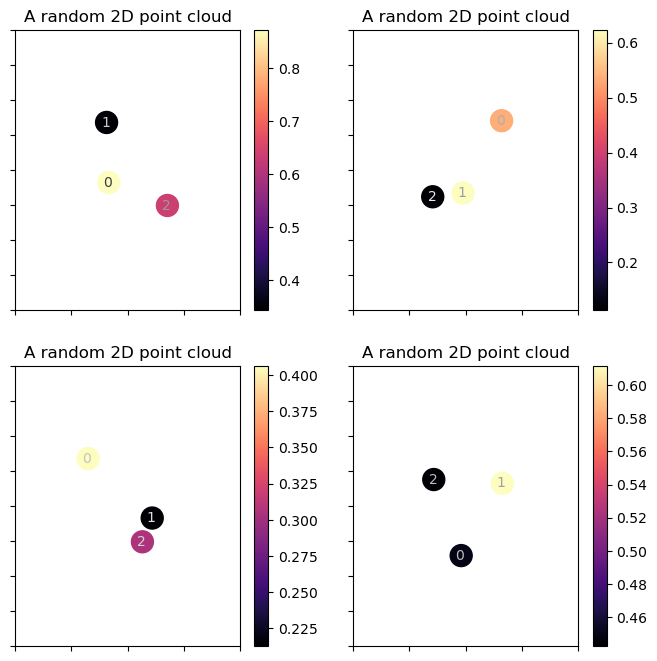

In [3]:
def to_perceived_brightness(rgb: np.ndarray) -> np.ndarray:
    """Convert rgb colors to perceived brighness values in [0,1]

    Parameters
    ----------
    rgb : np.ndarray
        _description_

    Returns
    -------
    np.ndarray
        _description_
    """
    r, g, b = rgb
    return 0.1 * r + 0.8 * g + 0.1 * b

def plot_point_cloud_2d(
    color: np.ndarray,
    pos: np.ndarray,
    cmap: mpl.colors.Colormap = mpl.colormaps["magma"],
    ax: Optional[mpl.axis.Axis] = None,
    point_size: float = 250.0,
    label_axes: bool = False,
    normalize_pos: bool = True,
    annotate_points: bool = True,
):
    """_summary_

    Parameters
    ----------
    color : np.ndarray
        _description_
    pos : np.ndarray
        _description_
    cmap : mpl.colors.Colormap, optional
        _description_, by default mpl.colormaps["magma"]
    ax : Optional[mpl.axis.Axis], optional
        _description_, by default None
    point_size : float, optional
        _description_, by default 250.0
    label_axes : bool, optional
        _description_, by default False
    normalize_pos : bool, optional
        _description_, by default True
    annotate_points : bool, optional
        _description_, by default True
    """
    if ax is None:
        fig, ax = plt.subplots()
    # normalize coordinates for better comparability
    # when comparing point clouds
    if normalize_pos:
        pos = (pos - pos.mean(axis=1, keepdims=True)) / pos.std(axis=1, keepdims=True)
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
    x, y = pos
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if label_axes:
        ax.set_xlabel("$x$ coordinate")
        ax.set_ylabel("$y$ coordinate")
    sc = ax.scatter(x, y, c=color, cmap=cmap, s=point_size)
    plt.colorbar(sc)
    if annotate_points:
        _colors = cmap(color)
        rgb = np.transpose(_colors)[:3, :]
        brightness = to_perceived_brightness(rgb)
        for i, (xi, yi, li) in enumerate(zip(x, y, brightness)):
            text = f"${i}$"
            num_digits = len(text) - 2
            offset = (-4 -2*num_digits, -4)
            ax.annotate(
                text="$%d$" % i,
                xy=(xi, yi),
                xytext=offset,
                textcoords="offset pixels",
                # annotation color based on perceived color brightness
                # for readability
                color=[1 - li] * 3
            )
            

# testing
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,8))
for ax in chain(*axes):
    pos = np.random.rand(2, 3)
    color = np.random.rand(3)
    ax.set_title("A random 2D point cloud")
    plot_point_cloud_2d(color, pos, ax=ax)
    

In [4]:
def plot_model_input(data: Data, ax: mpl.axis.Axis):
    """_summary_

    Parameters
    ----------
    data : Data
        _description_
    ax : mpl.axis.Axis
        _description_
    """
    x, pos = data.x, data.pos 
    # use atomic number as color
    x = x[:, 0].flatten().detach().numpy()
    pos = pos.T.detach().numpy()
    plot_point_cloud_2d(x, pos, ax=ax, normalize_pos=False)

def plot_model_embedding(data: Data, model: Callable[[Data], Tensor], ax: mpl.axis.Axis):
    """_summary_

    Parameters
    ----------
    data : Data
        _description_
    model : Callable[[Data], Tensor]
        _description_
    ax : mpl.axis.Axis
        _description_
    """
    x = model(data)
    pos = data.pos
    x = x.flatten().detach().numpy()
    pos = pos.T.detach().numpy()
    plot_point_cloud_2d(x, pos, ax=ax, normalize_pos=False)

### Set up QM9 dataset

We use the QM9 dataset already included in pytorch geometric. For the sake of this tutorial we will restrict ourselves to small molecules with at most 8 heavy atoms. Because we want to ignore structural information and treat molecules as point clouds, where every atom interacts with every other atom, we extend the date with additional adjacency information that represents a complete graph without self loops.

We do this *once* when pre-processing the data.

In [31]:
def num_heavy_atoms(qm9_data: Data) -> int:
    """Count the number of heavy atoms in a torch geometric
    Data object where atomic number is the *zeroth* atom (node)
    feature in `Data.x`

    Parameters
    ----------
    qm9_data : Data
        A pytorch geometric qm9 data object representing a small molecule

    Returns
    -------
    int
        The number of heavy atoms in the molecule.
    """
    # every atom with atomic number other than 1 is heavy
    # the torch geometric qm9 dataset stores
    # the atomic number in the first (zeroth)
    # node-feature channel
    return (qm9_data.x[:, 0] != 1).sum()


def complete_edge_index(n: int) -> LongTensor:
    # filter removes self loops
    edges = list(filter(lambda e: e[0] != e[1], product(range(n), range(n))))
    return torch.tensor(edges, dtype=torch.long).T


def add_complete_graph_edge_index(data: Data) -> Data:
    data.complete_edge_index = complete_edge_index(data.x.size(0))
    return data


#
dataset = QM9(
    "data",
    # filter out molecules with more than 8 heavy atoms
    pre_filter=lambda data: num_heavy_atoms(data) < 9,
    # implement point cloud adjacency as a complete graph
    pre_transform=add_complete_graph_edge_index,
)

print(
    f"Num. examples in QM9 restricted to molecules with at most 8 heavy atoms: {len(dataset)}"
)


Num. examples in QM9 restricted to molecules with at most 8 heavy atoms: 21800


The QM9 dataset includes 19 different targets but we will restrict ourselves to the [electronic spatial extent](TODO), which, simply put, describes the volume of a molecule. In order to improve training performance we will standardize the target.

In [32]:
def select_and_scale_target(
    qm9_data: Data,
    target_idx: int = 5,
    target_mean: float = 0,
    target_std: float = 1,
) -> Data:
    """ TODO

    Parameters
    ----------
    qm9_data : Data
        _description_

    Returns
    -------
    Data
        _description_
    """
    qm9_data.y = (qm9_data.y[:, target_idx].view(-1,1) - target_mean) / target_std
    return qm9_data

In [33]:
target_idx = 5 # electronic spatial extent has idx 5 in torch geometric
y = dataset.data.y[:, target_idx]

# store this for later, s.t. we can rescale validation mae by the original standard dev.
mean, std = y.mean(0).item(), y.std(0).item()

dataset = QM9(
    "data",
    pre_filter=lambda data: num_heavy_atoms(data) < 9,
    pre_transform=add_complete_graph_edge_index,
    # select a target and make sure it is scaled to have mean 0 and std. 1
    transform=partial(select_and_scale_target, target_idx=target_idx, target_mean=mean, target_std=std),
)


Now we set up a random training, validation and test splits on which we will train and evaluate our model later on.

In [47]:
num_examples = len(dataset)

# percentages of the data used for train/val/test data
train_ratio = 0.8
val_ratio = 0.1

# random train/val/test split
train_split = np.arange(int(train_ratio * num_examples))
val_split = np.arange(int(val_ratio * num_examples)) + train_split.shape[0]
test_split = np.arange(train_split.shape[0] + val_split.shape[0], num_examples)
shuffled_idxs = np.random.permutation(num_examples)
train_split = shuffled_idxs[train_split]
val_split = shuffled_idxs[val_split]
test_split = shuffled_idxs[test_split]

assert train_split.shape[0] + val_split.shape[0] + test_split.shape[0] == num_examples

Note: PyTorch Geometric stores node (atom) coordinates in a separate `Data` attribute named `pos`.

In [35]:
num_atoms, dimensions = dataset[0].pos.size()
num_atoms, dimensions

(5, 3)

### Demo: Plain GNNs are not E(3) invariant
A naive way to incorporate 3D coordinates into a GNN for molecular graphs would be to interpret them as atom-level features. 
It is easy to implement a transformation which does exactly this.

In [36]:
def add_coordinates_as_features(data: Data, num_spatial_dims_used: int = 3) -> Data:
    """Add separately stored atom coordinates
    to the node (atom) features of a molecular graph data object.

    Parameters
    ----------
    data : Data
        A pytorch geometric qm9 data object representing a small molecule
        
    num_spatial_dims_used : int
        Use the first `num_spatial_dims_used` as the coordinates.
        Helps with visualization, where we look at 2D point clouds.

    Returns
    -------
    Data
        Modified data object where the coordinates have been added as atom features.
    """
    new_data = data.clone()
    new_data.x = torch.cat((data.x, data.pos[:, :num_spatial_dims_used]), dim=-1)
    new_data.pos = data.pos[:, :num_spatial_dims_used]
    return new_data

However, this approach is problematic because the corresponding atom embeddings of a regular GNN (from which we would also derive our final predictions) will not be $\text{E}(3)$-invariant. This is easily demonstrated by visualizing the behavior of a plain GCN. To ease the visualization we restrict ourselves to 2D coordinates by first projecting the 3D-xyz coordinates to the z-plane.

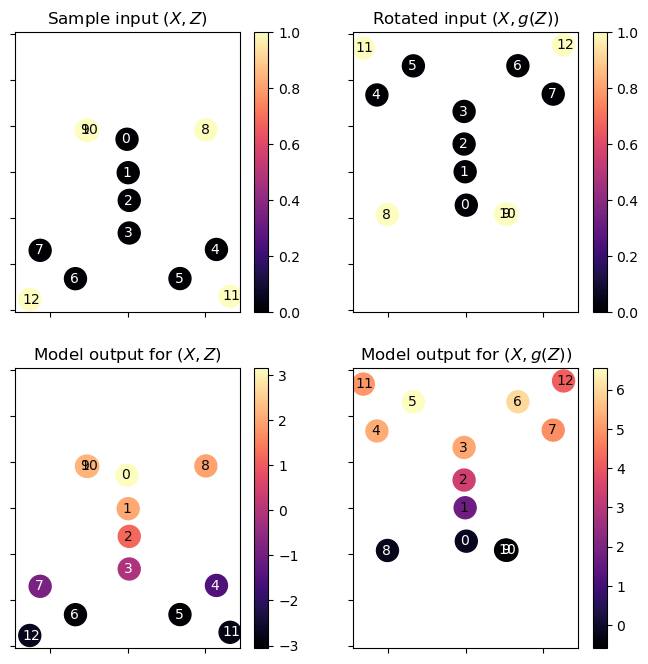

In [37]:
# some datapoint from qm9
sample_data = dataset[20160].clone()

# apply an E(2) transformation, in this case rotation by 180 degrees
rotated_sample_data = sample_data.clone()
rotated_sample_data.pos = - rotated_sample_data.pos

# prepare data for GCN
sample_data = add_coordinates_as_features(sample_data, num_spatial_dims_used=2)
rotated_sample_data = add_coordinates_as_features(rotated_sample_data, num_spatial_dims_used=2)

# initialize a GCN with 2 hidden layers that outputs 1-dimensional node embeddings
model = geom_nn.models.GCN(sample_data.x.size(1), 4, 2, 1)
model_fwd = lambda data: model(data.x, data.edge_index)

# make a plot that demonstrates non-equivariance
fig, axes = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)

axes[0][0].set_title("Sample input $(X, Z)$")
plot_model_input(sample_data, axes[0][0])

axes[0][1].set_title("Rotated input $(X, g(Z))$")
plot_model_input(rotated_sample_data, axes[0][1])

axes[1][0].set_title("Model output for $(X, Z)$")
plot_model_embedding(sample_data, model_fwd, axes[1][0])

axes[1][1].set_title("Model output for $(X, g(Z))$")
plot_model_embedding(rotated_sample_data, model_fwd, axes[1][1])
fig.tight_layout()

We can observe that rotating the molecule *significantly* alters the atom embeddings obtained from the GCN model.

<a id='egnn_model'></a>
### EGNN Model

We now implement an $\text{E}(3)$-invariant GNN based on the principles outlined in the [theory section](...).

In [38]:
# TODO thought this would be more complicated
# maybe can remove this function and do it inplace
def aggregate_messages(
    messages: Tensor, target_index: LongTensor, aggr: str = "sum"
) -> Tensor:
    return scatter(messages, target_index, dim=0, reduce=aggr)


class EquivariantMPLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        act: nn.Module,
        dropout: bool = True,
        drop_p: float = 0.2,
    ) -> None:
        super().__init__()
        self.act = act
        self.fn_dropout = nn.Dropout(drop_p) if dropout else nn.Identity()
        self.residual_proj = nn.Linear(in_channels, hidden_channels, bias=False)

        # message input: source node, target node, distance
        message_input_size = 2 * in_channels + 1
        # theory, equation (3) "phi_l"
        self.message_mlp = nn.Sequential(
            nn.Linear(message_input_size, hidden_channels),
            act,
            nn.Linear(hidden_channels, hidden_channels),
            act,
        )
        # theory, equation (4), "psi_l"
        self.node_update_mlp = nn.Sequential(
            nn.Linear(in_channels + hidden_channels, hidden_channels),
            act,
            nn.Linear(hidden_channels, hidden_channels),
        )

    def node_message_function(
        self,
        source_node_embed: Tensor,  # j
        target_node_embed: Tensor,  # i
        node_dist: Tensor,
    ):
        inp = torch.cat((source_node_embed, target_node_embed, node_dist), dim=-1)
        return self.message_mlp(inp)

    def compute_distances(self, node_pos: Tensor, edge_index: LongTensor) -> Tensor:
        row, col = edge_index
        xi, xj = node_pos[row], node_pos[col]
        # relative, squared distance
        # theory, equation (2) ||X_i - X_j||^2
        rsdist = (xi - xj).pow(2).sum(1, keepdim=True)
        return rsdist

    def forward(
        self,
        node_embed: Tensor,
        node_pos: Tensor,
        edge_index: Tensor,
    ) -> Tensor:
        row, col = edge_index
        dist = self.compute_distances(node_pos, edge_index)
        _node_embed = self.fn_dropout(node_embed)

        # compute messages "m_ij" from theory, equation (3)
        node_messages = self.node_message_function(
            _node_embed[row], _node_embed[col], dist
        )

        # aggregate messages for one node
        aggr_node_messages = aggregate_messages(node_messages, col, aggr="sum")

        # compute new node embeddings, i.e. theory, equation (4)
        new_node_embed = self.residual_proj(node_embed) + self.node_update_mlp(
            torch.cat((node_embed, aggr_node_messages), dim=-1)
        )

        return new_node_embed


class EquivariantGNN(nn.Module):
    def __init__(
        self,
        num_node_features: int,
        hidden_channels: int,
        output_channels: Optional[int] = None,
        target_size: int = 1,
        num_mp_layers: int = 2,
        dropout: bool = True,
        p_drop: float = 0.2,
    ) -> None:
        super().__init__()
        self.fn_dropout = nn.Dropout(p_drop) if dropout else nn.Identity()
        if output_channels is None:
            output_channels = hidden_channels

        # non-lienar activation func.
        # usually configurable, here we just use relu for simplicity
        self.act = nn.ReLU()

        # theory, equation (1) "psi_0"
        self.initial_mlp = nn.Linear(num_node_features, hidden_channels)
        channels = [hidden_channels] * (num_mp_layers) + [output_channels]
        self.message_passing_layers = nn.ModuleList()
        for d_in, d_out in zip(channels[:-1], channels[1:]):
            layer = EquivariantMPLayer(
                d_in, d_out, self.act, dropout=dropout, drop_p=p_drop
            )
            self.message_passing_layers.append(layer)

        self.aggregation = geom_nn.aggr.MeanAggregation()
        self.f_predict = nn.Sequential(
            self.fn_dropout,
            nn.Linear(output_channels, output_channels),
            self.act,
            nn.Linear(hidden_channels, target_size),
        )

    def encode(self, data: Data):
        # theory, equation (1)
        node_embed = self.initial_mlp(data.x)
        # message passing
        for mp_layer in self.message_passing_layers:
            # NOTE we here use the complete edge index defined by the transform earlier on
            node_embed = mp_layer(node_embed, data.pos, data.complete_edge_index)
        return node_embed

    def predict(self, node_embed, batch):
        aggr = self.aggregation(node_embed, batch)
        return self.f_predict(aggr)

    def forward(self, data: Data) -> torch.Tensor:
        node_embed = self.encode(data)
        pred = self.predict(node_embed, data.batch)
        return pred


We can collect evidence that this model is indeed $\text{E}(n)$ equivariant by repeating the experiment we performed earlier with the plain GCN model.

In [39]:
model = EquivariantGNN(
    num_node_features=dataset[0].x.size(1),
    hidden_channels=16,
    output_channels=1,
    dropout=False
)

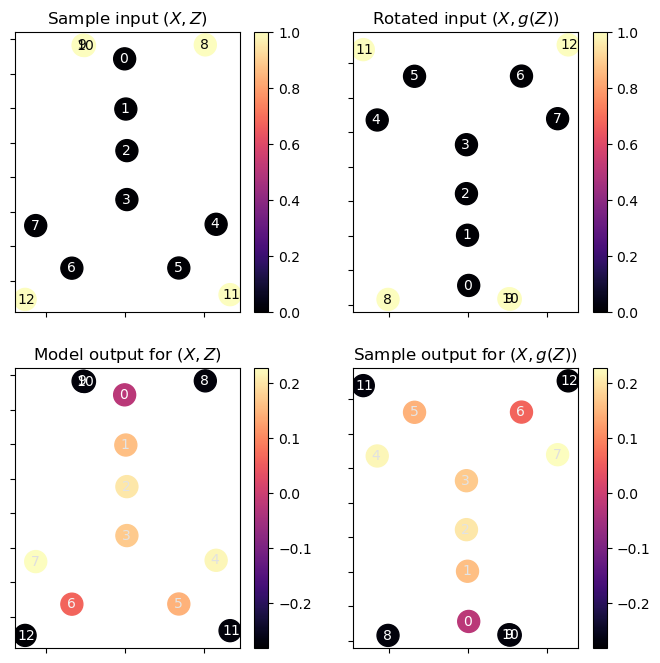

In [40]:
# idx = np.random.randint(len(dataset))
idx = 20160
data = dataset[idx].clone()

# project xyz coordinates onto z-plane
data.pos = data.pos[:, :2]

# rotate clockwise by 180 degrees
rotated_data = data.clone()
rotated_data.pos = -data.pos


fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0][0].set_title("Sample input $(X, Z)$")
plot_model_input(data, ax[0][0])

ax[0][1].set_title("Rotated input $(X, g(Z))$")
plot_model_input(rotated_data, ax[0][1])

ax[1][0].set_title("Model output for $(X, Z)$")
plot_model_embedding(data, model.encode, ax[1][0])

ax[1][1].set_title("Sample output for $(X, g(Z))$")
plot_model_embedding(rotated_data, model.encode, ax[1][1])
fig.tight_layout()


### EGNN Model training

In [41]:
# we will be using mean absolute error
# for validation and testing
def total_absolute_error(pred: Tensor, target: Tensor, batch_dim: int = 0) -> Tensor:
    return (pred - target).abs().sum(batch_dim)

In [54]:
def training_step(
    model: nn.Module,
    data_batch: Data,
    optim: torch.optim.Optimizer,
    criterion: Callable[[Tensor, Tensor], Tensor],
) -> float:
    optim.zero_grad()
    pred = model.forward(data_batch)
    target = data_batch.y
    loss = criterion(pred, target)
    loss.backward()
    optim.step()
    return loss.detach().item()


@torch.no_grad()
def validation_step(
    model: nn.Module,
    data_batch: Data,
    std: float,
) -> float:
    pred = model.forward(data_batch)
    target = data_batch.y
    validation_measure = total_absolute_error(pred * std, target * std)
    return validation_measure.item()

def train(
    dataset: Dataset,
    target_idx: int,
    target_std: float,
    train_split: np.ndarray,
    val_split: np.ndarray,
    model: Optional[nn.Module] = None,
    num_epochs: int = 30,
    lr: float = 3e-4,
    batch_size: int = 32,
    model_path: Path = DATA.joinpath("trained_model.pth")
) -> Dict[str, Any]:
    # initialize model if not given
    # TODO this is ugly. Remove
    # or expose model kwargs in function signature
    if model is None:
        num_node_features = dataset[0].x.size(1)
        model = EquivariantGNN(
            num_node_features=num_node_features,
            hidden_channels=50,
            target_size=1,
            num_mp_layers=2,
            dropout=True,
            p_drop=0.25
        )

    # create data loaders
    train_loader = DataLoader(dataset[train_split], batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset[val_split], batch_size=batch_size)

    for i, data in enumerate(dataset):
        assert data.y.size(1) == 1, i

    # setup optimizer and loss
    optim = torch.optim.Adam(model.parameters(), lr)
    loss_fn = nn.MSELoss()
    
    # keep track of the epoch with best validation mae
    # st we can save the "best" model weights
    best_val_mae = float("inf")
    
    # storage for plotting the loss curves later on
    train_losses = np.empty(num_epochs)
    val_maes = np.empty(num_epochs)

    for i_epoch in range(1, num_epochs + 1):
        print(f"Epoch {i_epoch} / {num_epochs}")

        # run training epoch
        model.train() # important: enables dropout layers
        pbar = tqdm(train_loader)
        total_train_loss = 0
        total_num_examples = 0
        for data in pbar:
            train_loss = training_step(model, data, optim, loss_fn)
            total_train_loss += train_loss * data.num_graphs
            total_num_examples += data.num_graphs
            desc = f"   Training loss: {total_train_loss / total_num_examples:.3f}"
            pbar.set_description(desc)
        
        train_desc_len = len(desc)
        train_losses[i_epoch - 1] = total_train_loss / total_num_examples

        # run validation epoch
        model.eval() # important: disables dropout layers
        pbar = tqdm(val_loader)
        desc = "Validating..."
        desc = " " * (train_desc_len - len(desc)) + desc
        pbar.set_description(desc)
        val_mae = 0
        for data in pbar:
            val_mae += validation_step(model, data, target_std)

        val_mae = val_mae / len(val_split)
        print(f"   Validation MAE: {val_mae:.3f}")
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            torch.save(model.state_dict(), model_path)
        
        val_maes[i_epoch - 1] = val_mae
        
    return {
        "model": model,
        "path_to_best_model": model_path,
        "train_loss": train_losses,
        "val_mae": val_maes,
    }


In [55]:
# use the data split and target defined earlier
egnn_train_result = train(
    dataset,
    target_idx,
    std,
    train_split,
    val_split,
    num_epochs=25,
    lr=3e-4,
    batch_size=32,
    model_path=DATA.joinpath("trained_egnn.pth")
)


Epoch 1 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 65.11it/s]


   Validation MAE: 28.857
Epoch 2 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 67.59it/s]


   Validation MAE: 34.014
Epoch 3 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 67.11it/s]


   Validation MAE: 23.841
Epoch 4 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 61.38it/s]


   Validation MAE: 19.316
Epoch 5 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 63.87it/s]


   Validation MAE: 16.546
Epoch 6 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 57.62it/s]


   Validation MAE: 27.762
Epoch 7 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 59.57it/s]


   Validation MAE: 33.478
Epoch 8 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 53.70it/s]


   Validation MAE: 14.410
Epoch 9 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 67.44it/s]


   Validation MAE: 23.766
Epoch 10 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 64.02it/s]


   Validation MAE: 21.856
Epoch 11 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 64.99it/s]


   Validation MAE: 17.299
Epoch 12 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 54.66it/s]


   Validation MAE: 34.979
Epoch 13 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 67.94it/s]


   Validation MAE: 30.133
Epoch 14 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 64.69it/s]


   Validation MAE: 20.311
Epoch 15 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 58.41it/s]


   Validation MAE: 38.268
Epoch 16 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 66.12it/s]


   Validation MAE: 39.023
Epoch 17 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 66.57it/s]


   Validation MAE: 38.255
Epoch 18 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 63.64it/s]


   Validation MAE: 32.682
Epoch 19 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 65.93it/s]


   Validation MAE: 32.559
Epoch 20 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 61.67it/s]


   Validation MAE: 26.567
Epoch 21 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 68.66it/s]


   Validation MAE: 30.799
Epoch 22 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 67.62it/s]


   Validation MAE: 45.995
Epoch 23 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 67.24it/s]


   Validation MAE: 27.331
Epoch 24 / 25


          Validating...: 100%|██████████| 69/69 [00:01<00:00, 65.61it/s]


   Validation MAE: 30.023
Epoch 25 / 25


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 69.72it/s]

   Validation MAE: 24.497


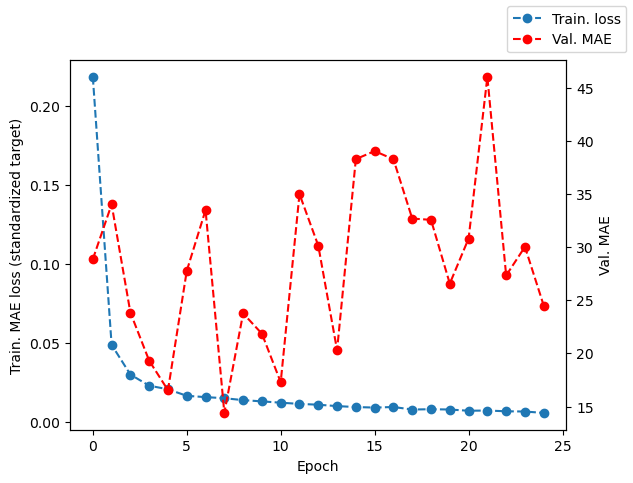

In [56]:

fig, ax = plt.subplots()

ax.plot(egnn_train_result["train_loss"], "o--", label="Train. loss")
ax.set_ylabel("Train. MAE loss (standardized target)")
ax.set_xlabel("Epoch")
#ax.set_yscale("log")

ax2 = ax.twinx()
ax2.set_ylabel("Val. MAE")
ax2.plot(egnn_train_result["val_mae"], "o--", label="Val. MAE", color="red")
fig.legend()

In [49]:
@torch.no_grad()
def test(model: nn.Module, test_split: np.ndarray, dataset: Dataset, target_std: float):
    test_loader = DataLoader(dataset[test_split], batch_size=16)
    test_mae = 0
    for data in test_loader:
        pred = model(data)
        test_mae += total_absolute_error(pred * target_std, data.y * target_std).item()
    
    test_mae = test_mae / len(test_split)
    
    return test_mae

13.218847091044855

In [ ]:
trained_model = egnn_train_result["model"]

# load the best model weights according to val. MAE
trained_model.load_state_dict(torch.load(Path("data", "trained_model.pth")))

egnn_test_mae = test(trained_model, test_split, dataset, std)
egnn_test_mae

In [51]:
class GCNBaseline(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
        self.gcn = geom_nn.models.GCN(dataset.data.x.size(1) + 3, 50, 2)
        self.aggregation = geom_nn.aggr.SumAggregation()
        self.f_predict = nn.Sequential(
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )
    
    def forward(self, data: Data) -> Tensor:
        node_embed = self.gcn(data.x, data.edge_index)
        aggr = self.aggregation(node_embed, data.batch)
        return self.f_predict(aggr)
        

gcn_baseline = GCNBaseline()

gcn_train_result = train(
    dataset,
    target_idx,
    std,
    train_split,
    val_split,
    gcn_baseline,
    lr=3e-4,
    batch_size=32
)

Epoch 1 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 121.04it/s]


   Validation MAE: 115.960
Epoch 2 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 125.10it/s]


   Validation MAE: 104.578
Epoch 3 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 111.60it/s]


   Validation MAE: 99.621
Epoch 4 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 120.44it/s]


   Validation MAE: 96.720
Epoch 5 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 110.10it/s]


   Validation MAE: 93.213
Epoch 6 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 101.72it/s]


   Validation MAE: 85.978
Epoch 7 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 97.49it/s]


   Validation MAE: 85.544
Epoch 8 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 104.71it/s]


   Validation MAE: 79.685
Epoch 9 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 106.81it/s]


   Validation MAE: 77.208
Epoch 10 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 109.28it/s]


   Validation MAE: 86.883
Epoch 11 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 96.44it/s] 


   Validation MAE: 76.972
Epoch 12 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 111.38it/s]


   Validation MAE: 68.561
Epoch 13 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 108.16it/s]


   Validation MAE: 66.483
Epoch 14 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 105.02it/s]


   Validation MAE: 65.921
Epoch 15 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 107.84it/s]


   Validation MAE: 71.034
Epoch 16 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 109.41it/s]


   Validation MAE: 61.033
Epoch 17 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 115.13it/s]


   Validation MAE: 61.827
Epoch 18 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 107.16it/s]


   Validation MAE: 61.696
Epoch 19 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 113.27it/s]


   Validation MAE: 56.639
Epoch 20 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 112.46it/s]


   Validation MAE: 57.084
Epoch 21 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 107.27it/s]


   Validation MAE: 55.267
Epoch 22 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 100.87it/s]


   Validation MAE: 61.292
Epoch 23 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 101.41it/s]


   Validation MAE: 54.336
Epoch 24 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 115.99it/s]


   Validation MAE: 52.544
Epoch 25 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 115.51it/s]


   Validation MAE: 53.088
Epoch 26 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 104.20it/s]


   Validation MAE: 54.681
Epoch 27 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 101.26it/s]


   Validation MAE: 52.171
Epoch 28 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 93.80it/s]


   Validation MAE: 52.003
Epoch 29 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 105.11it/s]


   Validation MAE: 49.970
Epoch 30 / 30


          Validating...: 100%|██████████| 69/69 [00:00<00:00, 101.00it/s]

   Validation MAE: 53.258


## Discussion

* Discuss vector valued features
* Discuss implementation with dense edge/adjacency tensor instead of sparse tensors
* Discuss reflections SE vs E

## Quiz

Ask three questions that the user should be able to answer after doing this talktorial. Choose important take-aways from this talktorial for your questions.

1. Question
2. Question
3. Question

<div class="alert alert-block alert-info">

<b>Useful checks at the end</b>: 
    
<ul>
<li>Clear output and rerun your complete notebook. Does it finish without errors?</li>
<li>Check if your talktorial's runtime is as excepted. If not, try to find out which step(s) take unexpectedly long.</li>
<li>Flag code cells with <code># NBVAL_CHECK_OUTPUT</code> that have deterministic output and should be tested within our Continuous Integration (CI) framework.</li>
</ul>

</div>